# Installation of packages

## install mamba

In [4]:
 ! mamba install -y pynco pynio pyngl


                  __    __    __    __
                 /  \  /  \  /  \  /  \
                /    \/    \/    \/    \
███████████████/  /██/  /██/  /██/  /████████████████████████
              /  / \   / \   / \   / \  \____
             /  /   \_/   \_/   \_/   \    o \__,
            / _/                       \_____/  `
            |/
        ███╗   ███╗ █████╗ ███╗   ███╗██████╗  █████╗
        ████╗ ████║██╔══██╗████╗ ████║██╔══██╗██╔══██╗
        ██╔████╔██║███████║██╔████╔██║██████╔╝███████║
        ██║╚██╔╝██║██╔══██║██║╚██╔╝██║██╔══██╗██╔══██║
        ██║ ╚═╝ ██║██║  ██║██║ ╚═╝ ██║██████╔╝██║  ██║
        ╚═╝     ╚═╝╚═╝  ╚═╝╚═╝     ╚═╝╚═════╝ ╚═╝  ╚═╝

        mamba (1.1.0) supported by @QuantStack

        GitHub:  https://github.com/mamba-org/mamba
        Twitter: https://twitter.com/QuantStack

█████████████████████████████████████████████████████████████


Looking for: ['pynco', 'pynio', 'pyngl']

[+] 0.0s
[+] 0.1s
conda-forge/linux-64 ━╸━━━━━━━━━━━━━━━╸━━━━━   0.0 B 

## install other packages

In [5]:
import gcsfs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import cftime
from nco import Nco
from tqdm import tqdm
import Ngl
import xesmf as xe

# Import files, add time, lat, lon dims

In [6]:
fs = gcsfs.GCSFileSystem()

In [7]:
fs.ls("gs://leap-persistent-ro/sungdukyu")

['leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr',
 'leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr',
 'leap-persistent-ro/sungdukyu/testing']

In [8]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.input.zarr')
ds_train_input = xr.open_dataset(mapper, engine='zarr')

In [9]:
ds_train_input.ymd.values[0], ds_train_input.tod.values[0]

(10201, 0)

In [10]:
# loop over all sample points
year=ds_train_input['ymd']//10000
month=ds_train_input['ymd']%10000//100
day=ds_train_input['ymd']%10000%100
hour=ds_train_input['tod']//3600
minute=ds_train_input['tod']%3600//60

k=0
t = []
for k in range(len(ds_train_input['ymd'])):
    t.append(cftime.DatetimeNoLeap(year[k],month[k],day[k],hour[k],minute[k]))

# add the time array to the 'sample' dimension; then, rename
ds_train_input['sample'] = t
ds_train_input = ds_train_input.rename({'sample':'time'})

# now 'time' dimension replaced 'sample' dimension.
ds_train_input = ds_train_input.drop(['tod','ymd'])

# Check the current **time** dimension, read the timestep
ds_train_input.time.values[0:5]

array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 20, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 40, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 20, 0, 0, has_year_zero=True)],
      dtype=object)

In [11]:
ds_train_input

<xarray.Dataset>
Dimensions:           (time: 210240, ncol: 384, lev: 60)
Coordinates:
  * time              (time) object 0001-02-01 00:00:00 ... 0009-01-31 23:40:00
Dimensions without coordinates: ncol, lev
Data variables: (12/27)
    cam_in_ALDIF      (time, ncol) float64 ...
    cam_in_ALDIR      (time, ncol) float64 ...
    cam_in_ASDIF      (time, ncol) float64 ...
    cam_in_ASDIR      (time, ncol) float64 ...
    cam_in_ICEFRAC    (time, ncol) float64 ...
    cam_in_LANDFRAC   (time, ncol) float64 ...
    ...                ...
    state_q0001       (time, lev, ncol) float64 ...
    state_q0002       (time, lev, ncol) float64 ...
    state_q0003       (time, lev, ncol) float64 ...
    state_t           (time, lev, ncol) float64 ...
    state_u           (time, lev, ncol) float64 ...
    state_v           (time, lev, ncol) float64 ...
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [12]:
train_x = ds_train_input[['pbuf_LHFLX','state_ps']].resample(time='1M').mean(dim='time')



In [13]:
mapper = fs.get_mapper('leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.train.output.zarr')
ds_train_output = xr.open_dataset(mapper, engine='zarr')

In [14]:
# loop over all sample points
year=ds_train_output['ymd']//10000
month=ds_train_output['ymd']%10000//100
day=ds_train_output['ymd']%10000%100
hour=ds_train_output['tod']//3600
minute=ds_train_output['tod']%3600//60

k=0
t = []
for k in range(len(ds_train_output['ymd'])):
    t.append(cftime.DatetimeNoLeap(year[k],month[k],day[k],hour[k],minute[k]))

# add the time array to the 'sample' dimension; then, rename
ds_train_output['sample'] = t
ds_train_output = ds_train_output.rename({'sample':'time'})

# now 'time' dimension replaced 'sample' dimension.
ds_train_output = ds_train_output.drop(['tod','ymd'])

# Check the current **time** dimension, read the timestep
ds_train_output.time.values[0:5]

array([cftime.DatetimeNoLeap(1, 2, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 20, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 0, 40, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1, 2, 1, 1, 20, 0, 0, has_year_zero=True)],
      dtype=object)

In [15]:
ds_train_output['cam_out_PRECT'] = ds_train_output['cam_out_PRECC'] + ds_train_output['cam_out_PRECSC']
train_y = ds_train_output[['cam_out_PRECT']].resample(time='1M').mean(dim='time')

In [16]:
train_y

<xarray.Dataset>
Dimensions:        (time: 96, ncol: 384)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
Dimensions without coordinates: ncol
Data variables:
    cam_out_PRECT  (time, ncol) float64 1.826e-09 1.298e-08 ... 3.901e-08
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [17]:
# grid info
mapper = fs.get_mapper("gs://leap-persistent-ro/sungdukyu/E3SM-MMF_ne4.grid-info.zarr")
ds_grid = xr.open_dataset(mapper, engine='zarr')
ds_grid

<xarray.Dataset>
Dimensions:  (ncol: 384, ilev: 61, lev: 60)
Dimensions without coordinates: ncol, ilev, lev
Data variables:
    P0       float64 ...
    area     (ncol) float64 ...
    hyai     (ilev) float64 ...
    hyam     (lev) float64 ...
    hybi     (ilev) float64 ...
    hybm     (lev) float64 ...
    lat      (ncol) float64 ...
    lon      (ncol) float64 ...
Attributes: (12/19)
    Conventions:       CF-1.7
    case:              E3SM_ML.GNUGPU.F2010-MMF1.ne4pg2_ne4pg2
    contact:           e3sm-data-support@listserv.llnl.gov
    fv_nphys:          2
    git_version:       4108bd8c11
    history:           created on 01/13/23 15:30:04
    ...                ...
    source:            E3SM Atmosphere Model
    source_id:         4108bd8c11
    time_period_freq:  month_1
    title:             EAM History file information
    topography_file:   /global/cfs/cdirs/e3sm/inputdata/atm/cam/topo/USGS-gto...
    username:          sungduk

In [18]:
print('column number is ',len(np.unique(ds_grid.ncol.values)))
print('if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is', len(np.unique(ds_grid.lat.values))*len(np.unique(ds_grid.lon.values)))
np.unique(ds_grid.lon.values.round(2))

column number is  384
if each lat occured in the data can be paired with a lon, the (lat,lon) grid number is 17313


array([  5.63,   5.65,   5.68,   5.73,   6.97,  10.54,  16.89,  16.91,
        16.96,  17.02,  18.06,  20.4 ,  28.15,  28.2 ,  28.31,  28.47,
        29.62,  33.28,  39.4 ,  39.46,  39.56,  39.73,  45.  ,  50.27,
        50.44,  50.54,  50.6 ,  56.72,  60.38,  61.53,  61.69,  61.8 ,
        61.85,  69.6 ,  71.94,  72.98,  73.04,  73.09,  73.11,  79.46,
        83.03,  84.27,  84.32,  84.35,  84.37,  95.63,  95.65,  95.68,
        95.73,  96.97, 100.54, 106.89, 106.91, 106.96, 107.02, 108.06,
       110.4 , 118.15, 118.2 , 118.31, 118.47, 119.62, 123.28, 129.4 ,
       129.46, 129.56, 129.73, 135.  , 140.27, 140.44, 140.54, 140.6 ,
       146.72, 150.38, 151.53, 151.69, 151.8 , 151.85, 159.6 , 161.94,
       162.98, 163.04, 163.09, 163.11, 169.46, 173.03, 174.27, 174.32,
       174.35, 174.37, 185.63, 185.65, 185.68, 185.73, 186.97, 190.54,
       196.89, 196.91, 196.96, 197.02, 198.06, 200.4 , 208.15, 208.2 ,
       208.31, 208.47, 209.62, 213.28, 219.4 , 219.46, 219.56, 219.73,
      

In [19]:
# original lat and lon info
lat = ds_grid.lat.values.round(2) 
lon = ds_grid.lon.values.round(2) 

# merge the original grid info with the dataset containing atmos variables
ds_multiindex = train_x.copy()
ds_multiindex['lat'] = (('ncol'),lat.T) # (('sample', 'ncol'),lat.T)
ds_multiindex['lon'] = (('ncol'),lon.T)

# set multi-index for the original dataset using lat and lon
ds_multiindex = ds_multiindex.set_index(index_id=["lat", "lon"])
index_id = ds_multiindex.index_id
ds_multiindex = ds_multiindex.drop('index_id')
ds_multiindex = ds_multiindex.rename({'ncol':'index_id'})
ds_multiindex = ds_multiindex.assign_coords(index_id = index_id)
ds_multiindex

<xarray.Dataset>
Dimensions:     (time: 96, index_id: 384)
Coordinates:
  * time        (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * lat         (index_id) float64 -32.59 -35.99 -22.69 ... 45.34 45.34 40.39
  * lon         (index_id) float64 320.3 331.5 320.4 331.7 ... 123.3 146.7 135.0
  * index_id    (index_id) object MultiIndex
Data variables:
    pbuf_LHFLX  (time, index_id) float64 43.62 46.79 96.59 ... 3.039 90.37 90.46
    state_ps    (time, index_id) float64 1.008e+05 1.015e+05 ... 9.983e+04
Attributes:
    calendar:  NO_LEAP
    fv_nphys:  2
    ne:        4

In [20]:
# create a dataset with stacked (lat, lon) grids in the original dataset, all values are NaNs
time = train_x.time.values

data_np = np.empty(shape=(len(time), len(np.unique(lat)),len(np.unique(lon))))
data_np[:,:] = np.nan

ds_latlon = xr.Dataset(
     data_vars={
         # v: (("time","index_id"), np.zeros([len(time), len(np.unique(lat))*len(np.unique(lon))]))
         v: (("time","lat","lon"), data_np)
         for v in ['pbuf_LHFLX','state_ps']
     },
     coords={
         "time": train_x.time,
         # "index_id": pd.MultiIndex.from_product(
         #    [np.unique(lat), np.unique(lon)], names=["lat", "lon"],),
         "lat": np.unique(lat),
         "lon": np.unique(lon),
         # "lev": ds.lev,
    },
)

# use multi-index so that we can assign the column data to the (lat,lon) data
ds_latlon = ds_latlon.stack(index_id=['lat','lon'])
ds_latlon 

# print(len(ds_multiindex.index_id.values))
# ds_latlon.sel(index_id=(-32.59, 320.27))

<xarray.Dataset>
Dimensions:     (time: 96, index_id: 9360)
Coordinates:
  * time        (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * index_id    (index_id) object MultiIndex
  * lat         (index_id) float64 -82.06 -82.06 -82.06 ... 82.06 82.06 82.06
  * lon         (index_id) float64 5.63 5.65 5.68 5.73 ... 354.3 354.4 354.4
Data variables:
    pbuf_LHFLX  (time, index_id) float64 nan nan nan nan nan ... nan nan nan nan
    state_ps    (time, index_id) float64 nan nan nan nan nan ... nan nan nan nan

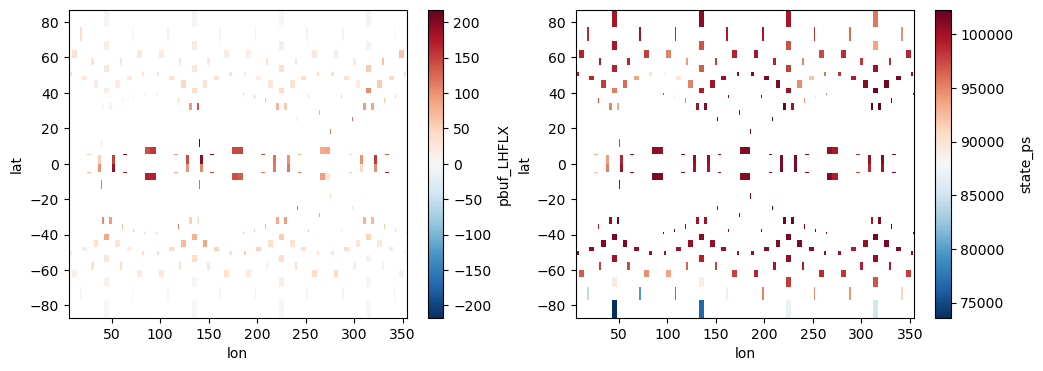

In [21]:
# use tqdm to visualize the progress of the below loop
# this cell takes about 20min to run, please patiently wait when it is run
latent_heat = ds_latlon.pbuf_LHFLX.copy()
surface_pressure = ds_latlon.state_ps.copy()

for i in (ds_multiindex.index_id.values):
    # ds_latlon.loc[{"index_id": i}] = ds_multiindex[[' cam_out_NETSW','cam_out_PRECC']].sel(index_id = i) 
    #### wrong, will lead to all vars have the same values
    latent_heat.loc[{"index_id": i}] = ds_multiindex['pbuf_LHFLX'].sel(index_id = i)
    surface_pressure.loc[{"index_id": i}] = ds_multiindex['state_ps'].sel(index_id = i)

ds_latlon['pbuf_LHFLX'] = latent_heat.copy()
ds_latlon['state_ps'] = surface_pressure.copy()

ds_unstack = ds_latlon.unstack('index_id')
ds_unstack

## if we directly visualize the 2D maps, then there are many missing values 
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
ds_unstack.pbuf_LHFLX.mean('time').plot(cmap='RdBu_r',ax=ax[0])
ds_unstack.state_ps.mean('time').plot(cmap='RdBu_r',ax=ax[1])

In [22]:
# original lat and lon info
ncol = train_x.ncol.values

# new lat and lon grids that we finally want
nlat = np.arange(-90, 90.5, 2)
nlon = np.arange(0, 360, 2)

# create a nan-value xr dataset to contain new remapped & interpolated data 
data_var = np.empty([len(time), len(nlat), len(nlon)])
data_var[:,:,:] = np.nan

new_train_x = xr.Dataset(
     data_vars={
         v: (("time","lat","lon"), data_var)
         for v in ['pbuf_LHFLX','state_ps']
     },
     coords={
         "time": train_x.time,
         "lat": nlat,
         "lon": nlon,
        # "lev": ds.lev,
    },
)

new_train_x

<xarray.Dataset>
Dimensions:     (time: 96, lat: 91, lon: 180)
Coordinates:
  * time        (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * lat         (lat) float64 -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
  * lon         (lon) int64 0 2 4 6 8 10 12 14 ... 346 348 350 352 354 356 358
Data variables:
    pbuf_LHFLX  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    state_ps    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [23]:
data_latent_heat = data_var.copy()
data_surface_pressure = data_var.copy()

# interpolate the data using pyngl
# optional: use multiprocessing to save the running time

for it, tt in enumerate(train_x.time):
    data = train_x.sel(time=tt).pbuf_LHFLX.values
    iarr = Ngl.natgrid(lat, lon, data, nlat, nlon) #.squeeze()
    data_latent_heat[it,:] = iarr
    
    data = train_x.sel(time=tt).state_ps.values
    iarr = Ngl.natgrid(lat, lon, data, nlat, nlon) #.squeeze()
    data_surface_pressure[it,:] = iarr

new_train_x['pbuf_LHFLX'].values = data_latent_heat
new_train_x['state_ps'].values = data_surface_pressure

Text(0.5, 1.0, 'Surface Pressure')

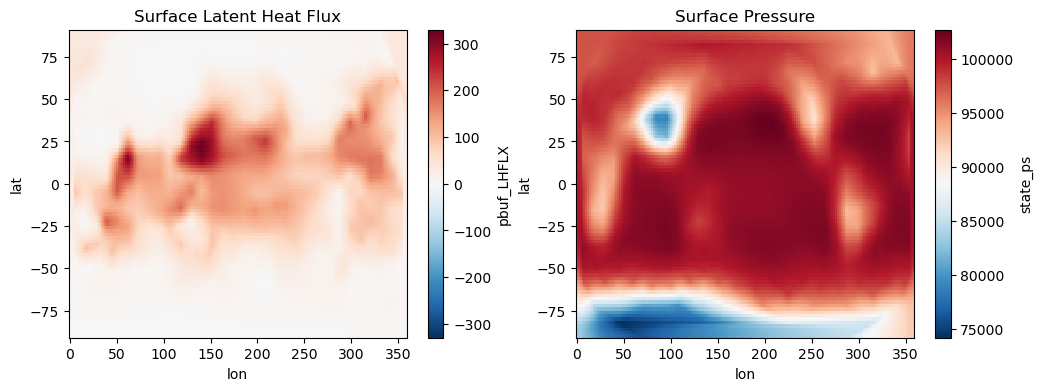

In [24]:
# plot the maps of these two variables at a specific time step

fig, ax = plt.subplots(ncols=2, figsize=(12,4))
new_train_x['pbuf_LHFLX'].isel(time=10).plot(cmap='RdBu_r',ax=ax[0])
new_train_x['state_ps'].isel(time=10).plot(cmap='RdBu_r',ax=ax[1])
ax[0].set_title('Surface Latent Heat Flux')
ax[1].set_title('Surface Pressure')

In [25]:
new_train_x

<xarray.Dataset>
Dimensions:     (time: 96, lat: 91, lon: 180)
Coordinates:
  * time        (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * lat         (lat) float64 -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
  * lon         (lon) int64 0 2 4 6 8 10 12 14 ... 346 348 350 352 354 356 358
Data variables:
    pbuf_LHFLX  (time, lat, lon) float64 1.158 1.079 0.5822 ... 34.28 34.46
    state_ps    (time, lat, lon) float64 8.393e+04 8.382e+04 ... 9.655e+04

## Import ds_new as y dataset

In [26]:
new_train_y = xr.open_dataset('ds_new.nc')

In [27]:
new_train_y

<xarray.Dataset>
Dimensions:        (time: 96, lat: 91, lon: 180)
Coordinates:
  * time           (time) object 0001-02-28 00:00:00 ... 0009-01-31 00:00:00
  * lat            (lat) float64 -90.0 -88.0 -86.0 -84.0 ... 84.0 86.0 88.0 90.0
  * lon            (lon) int64 0 2 4 6 8 10 12 ... 346 348 350 352 354 356 358
Data variables:
    cam_out_NETSW  (time, lat, lon) float64 ...
    cam_out_PRECT  (time, lat, lon) float64 ...

# Data fiddling for pysr

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

In [33]:
lhf = new_train_x.pbuf_LHFLX.mean(dim = ("lat","lon")).values
precip = new_train_y.cam_out_PRECT.mean(dim = ("lat","lon")).values

In [34]:
lhf.shape, precip.shape

((96,), (96,))

In [35]:
df = pd.DataFrame(columns=["lhf","precip"],data=np.array([lhf,precip]).transpose(),index=None)

<Axes: xlabel='lhf', ylabel='precip'>

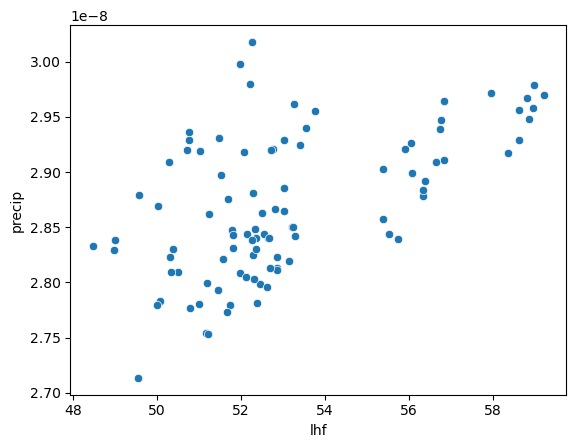

In [36]:
sns.scatterplot(x="lhf",y="precip",data=df)

In [37]:
X = np.array(df.drop("precip",axis=1))
y = np.array(df["precip"])

# PySR/julia installation

copy the following into your terminal
curl -fsSL https://install.julialang.org | sh
pip3 install -U pysr
python3 -m pysr install

solve path issue? python3 -c 'import os; print(os.environ["PATH"])'

then run the following code in the notebook you would like to use:
conda install -c conda-forge pysr

conda install -c conda-forge pysr

In [49]:
import os; print(os.environ["PATH"])

/srv/conda/envs/notebook/bin:/srv/conda/condabin:/srv/conda/envs/notebook/bin:/srv/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/nvidia/bin


In [ ]:
conda install -c conda-forge pysr

Retrieving notices: ...working... done
Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - conda-forge/noarch::python-graphviz==0.20.1=pyh22cad53_0
  - conda-forge/noarch::geogif==0.1.3=pyhd8ed1ab_0
  - conda-forge/linux-64::graphviz==7.1.0=h2e5815a_0
  - conda-forge/noarch::prefect==2.7.11=pyhd8ed1ab_0
  - conda-forge/linux-64::grpc-cpp==1.47.1=h05bd8bd_7
  - conda-forge/linux-64::libjpeg-turbo==2.1.4=h166bdaf_0
  - conda-forge/noarch::_ipython_minor_entry_point==8.7.0=hb6b4a82_0
  - conda-forge/linux-64::librsvg==2.54.4=h7abd40a_0
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: \ 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



- 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Examining conflict for esmpy gdal python-eccodes eccodes libgdal netcdf-fortra\ 

In [50]:
from pysr import pysr, best, best_callable

In [51]:
equations = pysr(
    X,
    y,
    niterations=2,
    binary_operators=["+", "*"],
    unary_operators=[
        "cos",
        "exp",
        "sin",
        "inv(x) = 1/x",
    ],
)

/srv/conda/envs/notebook/lib/python3.10/site-packages/pysr/sr.py:90: FutureWarning: Calling `pysr` is deprecated. Please use `model = PySRRegressor(**params); model.fit(X, y)` going forward.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.10/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


FileNotFoundError: Julia is not installed in your PATH. Please install Julia and add it to your PATH.

Current PATH: /srv/conda/envs/notebook/bin:/srv/conda/condabin:/srv/conda/envs/notebook/bin:/srv/conda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/local/nvidia/bin